# Unconditional sampling from $\mathbb{G}$

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np

class Unconditional(object):
    def __init__(self, dimension, generator, latent_size, latent_dist, use_cuda=False):
        self.use_cuda = use_cuda

        self.dimension = dimension
        self.generator = generator

        if self.use_cuda:
            self.generator = self.generator.cuda()

        self.latent_size = latent_size
        self.latent_dist = latent_dist

    def sample_batch(self, batch, m):
        config = [batch, self.latent_size]# + m
        zhat = None
        if self.use_cuda:
            zhat = Variable(torch.FloatTensor(*config).cuda(), requires_grad=True)
        else:
            zhat = Variable(torch.FloatTensor(*config), requires_grad=True)
        zhat.retain_grad()
        if self.latent_dist == "normal":
            zhat.data = zhat.data.normal_(0, 1)
        elif self.latent_dist == "uniform":
            zhat.data = zhat.data.uniform_(-1, 1)
        return zhat

    def create_unconditional_simulations(self, batch, m):
        zhat = self.sample_batch(batch, m)
        if self.use_cuda:
            zhat = zhat.cuda()
        try:
            xhat = self.generator(zhat)
            return xhat.data.cpu().numpy()
        except RuntimeError as reError:
            print(reError)

In [3]:
import os
import cv2
import yaml
import time
import torch
import shutil
import torchvision
import tensorboardX
import torch.nn as nn
import torchvision.transforms as transforms

from tqdm import tqdm
from imageio import imsave
from torch.autograd import grad
from torch.autograd import Variable
from skimage.util import view_as_windows


"""
WGAN-GP implementation.

This is an implementation of Wasserstein GANs with gradient penalty.
Link to the paper is : https://arxiv.org/pdf/1704.00028.pdf

Wasserstein GANs suggest a change in the distance function calculated while
 training any Generative Adverserial Network.
"""


class GeneratorModel(nn.Module):
    """
    Generator model for WGAN-GP.

    Given a vector of random values (latent inputs) as input, this network
    generates data with the same structure as the training data.
    The goal is to train the generator to generate data that "fools" the
    Critic.
    """

    def __init__(self, dim_in, dim: int = 128):
        super(GeneratorModel, self).__init__()

        def genblock(dim_in, dim_out):
            
            block = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_in,
                                                     out_channels=dim_out,
                                                     kernel_size=5,
                                                     stride=2,
                                                     padding=2,
                                                     output_padding=1,
                                                     bias=False),
                                  nn.BatchNorm2d(dim_out),
                                  nn.ReLU()
                                  )
            return block

        def genimg(dim_in):
            block = nn.Sequential(nn.ConvTranspose2d(in_channels=dim_in,
                                                     out_channels=1,
                                                     kernel_size=5,
                                                     stride=2,
                                                     padding=2,
                                                     output_padding=1,
                                                     ),
                                  nn.Tanh()
                                  )
            return block

        self.prepare = nn.Sequential(nn.Linear(dim_in, dim*8*4*4, bias=False),
                                     nn.BatchNorm1d(dim*8*4*4),
                                     nn.ReLU())
        self.generate = nn.Sequential(genblock(dim*8, dim*4),
                                      genblock(dim*4, dim*2),
                                      genblock(dim*2, dim*4),
                                      genblock(dim*4, dim*8),
                                      genimg(dim*8))

    def forward(self, x):
        """Forward pass function."""
        x = self.prepare(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.generate(x)
        return x

latent_size = 100

state_dict = torch.load(r"C:\Users\algocompretto\SharedCerberus\Epoch_(100).ckpt", map_location='cpu')

generator = GeneratorModel(latent_size)
generator.load_state_dict(state_dict["Generator"])


<All keys matched successfully>

In [47]:
uncond = Unconditional(1, generator, latent_size, "normal")
x = 1
for i in range(1, 100):
    samples = uncond.create_unconditional_simulations(100, [i, i, i])
    if samples is not None:
        print("Imsize: ", i, "Uncoditional Simulation Size: ", samples.shape)
samples_arr = np.where(np.concatenate(samples, 0)*0.5+0.5 >= 0.5, 1.0, 0.0)
np.save("array_generated", samples_arr, allow_pickle=True)

Imsize:  1 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  2 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  3 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  4 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  5 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  6 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  7 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  8 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  9 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  10 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  11 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  12 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  13 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  14 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  15 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  16 Uncoditional Simulation Size:  (100, 1, 128, 128)
Imsize:  17 Uncod

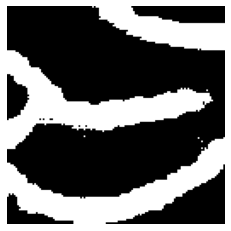

In [75]:
plt.imshow(samples_arr[2], 'gray')
plt.axis(False)
plt.grid(False)
plt.savefig(r"C:\Users\algocompretto\Downloads\im2.png", dpi=500,
           bbox_inches='tight')

# Convert `numpy` array to `gslib` format

# SNESIM program

In [50]:
# import numpy
# import pygeostat as gs
#
# from src.helpers.funcs import *
#
# snesim_model = gs.Program(program="gan_bin\\snesim.exe")
#
# for idx, im in enumerate(os.listdir("gan_bin/")):
#     if im.endswith('.out'):
#         par_string = f'''
#                 Parameters for SNESIM
#                  ***********************
#
#         START OF PARAMETERS:
#         samples50.out             - file with original data
#         1  2  3  4                    - columns for x, y, z, variable
#         2                             - number of categories
#         0   1                         - category codes
#         0.7  0.3                      - (target) global pdf
#         0                             - use (target) vertical proportions (0=no, 1=yes)
#         vertprop.dat                  - file with target vertical proportions
#         0                             - servosystem parameter (0=no correction)
#         -1                            - debugging level: 0,1,2,3
#         nsnesim.dbg                    - debugging file
#         {im.split('.')[0]+'_snesim'}.out    - file for simulation output
#         1                             - number of realizations to generate
#         150    0.5    1.0             - nx,xmn,xsiz
#         150    0.5    1.0             - ny,ymn,ysiz
#         1     0.5    1.0              - nz,zmn,zsiz
#         303258                        - random number seed
#         30                            - max number of conditioning primary data
#         10                            - min. replicates number
#         0 0                           - condtion to LP (0=no, 1=yes), flag for iauto
#         1.0 1.0                       - two weighting factors to combine P(A|B) and P(A|C)
#         localprop.dat                 - file for local proportions
#         0                             - condition to rotation and affinity (0=no, 1=yes)
#         rotangle.dat                  - file for rotation and affinity
#         3                             - number of affinity categories
#         1.0  1.0  1.0                 - affinity factors (X,Y,Z)
#         1.0  0.6  1.0                 - affinity factors
#         1.0  2.0  1.0                 - affinity factors
#         6                             - number of multiple grids
#         gan_bin/{im}          - file for training image
#         150  150  1                   - training image dimensions: nxtr, nytr, nztr
#         1                             - column for training variable
#         10.0   10.0   5.0             - maximum search radii (hmax,hmin,vert)
#         0.0    0.0   0.0              - angles for search ellipsoid
#         '''
#         #print(par_string)
#         snesim_model.run(par_string)
#
# # Setting the cat dictionary
# gs.Parameters['data.catdict'] = {1: 'Sandstone', 0: 'Shale'}
# gs.Parameters.describe('data.catdict')
#
# gs.Parameters['data.griddef'] = gs.GridDef([150, 0.5, 1.0,
#                                             150, 0.5, 1.0,
#                                             1.0, 0.5, 1.0])
#
# # Default plot settings
# gs.PlotStyle['font.size'] = 13
# gs.PlotStyle['figure.figsize'] = (16, 9)